In [23]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

import uproot4 as up

dir_tree = {}
dir_index = {}
v_keys = ["DSNB"]
v_num = ["","[1-4]"]
for i,key in enumerate(v_keys):
    tree_PSD = up.lazy(f"/afs/ihep.ac.cn/users/l/luoxj/scratchfs_juno_500G/TestPSD_offline/TestPSDTool/user_{key}_{v_num[i]}[0-9][0-9].root:PSD")
    R3 = np.array(tree_PSD["r3_tag"])
    Erec = np.array(tree_PSD["E_rec"])
    index = (R3<4096) & (Erec>10) & (Erec<31)
    dir_tree[key] = tree_PSD
    dir_index[key] = index

In [24]:
key = "DSNB"
v_atm = np.load("tmp_atm.pnz.npy")
v_DSNB = dir_tree[key]["psdVal"][dir_index[key]]
dir = {"atm":v_atm,"DSNB":v_DSNB}


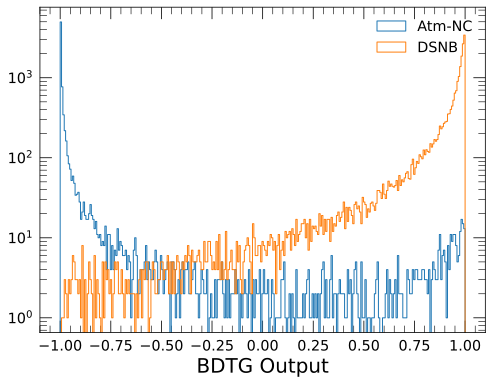

In [25]:
v_keys = ["atm","DSNB"]
dir_n0 = {}
bins=np.linspace(-1,1,300)
for key in dir.keys():
    # print(key,"\t",len(dir_tree[key]["psdVal"][dir_index[key]]))
    # n0, bins0, patches0 =plt.hist(np.array(dir_tree[key]["psdVal"][dir_index[key]]), bins=bins, histtype="step",
    #          label="Atm-NC" if key == "atm" else key )
    n0, bins0, patches0 =plt.hist(dir[key], bins=bins, histtype="step",
                                  label="Atm-NC" if key == "atm" else key )
    dir_n0[key] = n0
plt.semilogy()
plt.legend()
plt.xlabel("BDTG Output")
plt.savefig("./figure/BDTG_output.png")


(array(0.56269717), [<matplotlib.lines.Line2D object at 0x7fd1a43c9580>])


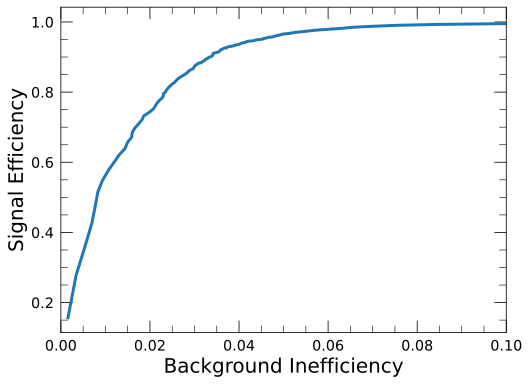

In [26]:
def GetSigEff( v_eff_sig, v_eff_bkg, certain_eff_bkg=0.01):
    from scipy.interpolate import interp1d
    v_eff_bkg = np.array(v_eff_bkg)
    v_eff_sig = np.array(v_eff_sig)
    f = interp1d(v_eff_bkg[1:], v_eff_sig[1:], kind="linear")
    eff_sig_return = f(certain_eff_bkg)
    return (certain_eff_bkg, eff_sig_return)

def GetSignalEfficiency(n0, n1,
                        label:str="", axes:plt.Axes=None,
                        ls=None,color=None, extra_label=""):
    # n0 = dir_events["PSD"][dir_events["tag"]==0]
    # n1 = dir_events["PSD"][dir_events["tag"]==1]
    certain_eff_bkg = 0.01
    if axes is None:
        axes = plt.subplot(111)
    eff_bkg = []
    eff_sig = []
    for i in range(len(n0)):
        eff_bkg.append(np.sum(n0[i:]) * 1.0 / np.sum(n0))
        eff_sig.append(np.sum(n1[i:]) * 1.0 / np.sum(n1))
    line = axes.plot(eff_bkg,eff_sig, label=label,
              ls=ls, color=color)
    if not extra_label=="":
        axes.plot(eff_bkg,eff_sig, label=extra_label,
                         ls=ls, color=line[0].get_color())

    (certain_eff_bkg, eff_sig_return) = GetSigEff(v_eff_bkg=eff_bkg, v_eff_sig=eff_sig,
                                                  certain_eff_bkg=certain_eff_bkg)
    return (eff_sig_return, line)

print(GetSignalEfficiency(dir_n0[v_keys[0]], dir_n0[v_keys[1]],bins))
plt.xlim(0, 0.1)
plt.xlabel("Background Inefficiency")
plt.ylabel("Signal Efficiency")
plt.savefig("./figure/ROC.png")